# Import module 

the network structure borrow from https://github.com/hwalsuklee/tensorflow-mnist-AAE

In [1]:
import os
import time
import scipy
from math import sin,cos,sqrt
from functools import reduce

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

# Loading MNIST data

In [3]:
os.environ['CUDA_VISIBLE_DEVICES']='4'
mnist = input_data.read_data_sets("data/mnist",one_hot=True)

Extracting data/mnist/train-images-idx3-ubyte.gz
Extracting data/mnist/train-labels-idx1-ubyte.gz
Extracting data/mnist/t10k-images-idx3-ubyte.gz
Extracting data/mnist/t10k-labels-idx1-ubyte.gz


# Helper Functions


In [19]:
def linear(net,wscope,bscope,output_depth):
    w_init = tf.contrib.layers.xavier_initializer()
    b_init = tf.constant_initializer(0.)

    shape = net.get_shape()       
    weights = tf.get_variable(wscope, [shape[-1], output_depth], initializer=w_init)
    biases = tf.get_variable(bscope, [output_depth], initializer=b_init)
    out_logit = tf.matmul(net, weights) + biases
    return out_logit
 
    
# borrowed from https://github.com/hwalsuklee/tensorflow-mnist-AAE/blob/master/plot_utils.py
def _discrete_cmap(y_dim, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""

    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:

    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, y_dim))
    cmap_name = base.name + str(y_dim)
    return base.from_list(cmap_name, color_list, y_dim)  


# borrowed from https://github.com/ykwon0407/variational_autoencoder/blob/master/variational_bayes.ipynb
def save_scattered_image(z, cur_label, y_dim, name='scattered_image.jpg'):
    
    plt.figure(figsize=(8, 6))
    plt.scatter(z[:, 0], z[:, 1], c=np.argmax(cur_label, 1), marker='o', edgecolor='none', cmap=_discrete_cmap(y_dim, 'jet'))
    plt.colorbar(ticks=range(y_dim))
    axes = plt.gca()
    axes.set_xlim([-4.5, 4.5])
    axes.set_ylim([-4.5, 4.5])
    plt.grid(True)
    plt.savefig(name)
        
        
def display(img_samples=None, z_samples=None, z_label=None, batch_size=None, y_dim=None, img_h=None, img_w=None, image_dims=None, step_ind=None, plot='reproduce'):
    
    if plot == 'reproduce':
        row = col = int(np.sqrt(batch_size))
        img = np.zeros( [row*img_h, col*img_w] )
        for i in range(row):
            for j in range(col):
                img[i*img_w:(i+1)*img_w, j*img_h:(j+1)*img_h] = img_samples[i*col+j, :].reshape(image_dims[:2])
        #save the result      
        scipy.misc.imsave('multi_{}.jpg'.format(step_ind),img)   
        
    elif plot == 'mainfold learning':
        row = col = int(np.sqrt(img_samples.shape[0]))
        img = np.zeros( [row*img_h, col*img_w] )
        for i in range(row):
            for j in range(col):
                img[i*img_w:(i+1)*img_w, j*img_h:(j+1)*img_h] = img_samples[i*col+j, :].reshape(image_dims[:2])
        scipy.misc.imsave('multi_{:04d}.jpg'.format(step_ind),img) 
      
        save_scattered_image(z_samples, z_label, y_dim, 'multi_{:04d}_scatter.jpg'.format(step_ind))
    else:
        raise Exception('you should not run here!')


# Prior Distribution Functions
here define four prior distribution, which will impose onto the hidden code vector of AAE.   
Most codes from https://github.com/musyoku/adversarial-autoencoder/blob/master/aae/sampler.py

In [5]:

def uniform(batch_size, n_dim, n_labels=10, minv=-1, maxv=1, label_indices=None):
    '''if label_indices is None, then uniform will call numpy.random.uniform()'''
    if label_indices is not None:
        if n_dim != 2 or n_labels != 10:
            raise Exception("n_dim must be 2 and n_labels must be 10.")

        def sample(label, n_labels):
            num = int(np.ceil(np.sqrt(n_labels)))
            size = (maxv-minv)*1.0/num
            x, y = np.random.uniform(-size/2, size/2, (2,))
            i = label / num
            j = label % num
            x += j*size+minv+0.5*size
            y += i*size+minv+0.5*size
            return np.array([x, y]).reshape((2,))

        z = np.empty((batch_size, n_dim), dtype=np.float32)
        for batch in range(batch_size):
            for zi in range((int)(n_dim/2)):
                    z[batch, zi*2:zi*2+2] = sample(label_indices[batch], n_labels)
    else:
        z = np.random.uniform(minv, maxv, (batch_size, n_dim)).astype(np.float32)
    return z

def gaussian(batch_size, n_dim, mean=0, var=1, n_labels=10, use_label_info=False):
    if use_label_info:
        if n_dim != 2 or n_labels != 10:
            raise Exception("n_dim must be 2 and n_labels must be 10.")

        def sample(n_labels):
            x, y = np.random.normal(mean, var, (2,))
            angle = np.angle((x-mean) + 1j*(y-mean), deg=True)
            dist = np.sqrt((x-mean)**2+(y-mean)**2)

            # label 0
            if dist <1.0:
                label = 0
            else:
                label = ((int)((n_labels-1)*angle))//360

                if label<0:
                    label+=n_labels-1

                label += 1

            return np.array([x, y]).reshape((2,)), label

        z = np.empty((batch_size, n_dim), dtype=np.float32)
        z_id = np.empty((batch_size), dtype=np.int32)
        for batch in range(batch_size):
            for zi in range((int)(n_dim/2)):
                    a_sample, a_label = sample(n_labels)
                    z[batch, zi*2:zi*2+2] = a_sample
                    z_id[batch] = a_label
        return z, z_id
    else:
        z = np.random.normal(mean, var, (batch_size, n_dim)).astype(np.float32)
        return z

def gaussian_mixture(batch_size, n_dim=2, n_labels=10, x_var=0.5, y_var=0.1, label_indices=None):
    if n_dim != 2:
        raise Exception("n_dim must be 2.")

    def sample(x, y, label, n_labels):
        shift = 1.4
        r = 2.0 * np.pi / float(n_labels) * float(label)
        new_x = x * cos(r) - y * sin(r)
        new_y = x * sin(r) + y * cos(r)
        new_x += shift * cos(r)
        new_y += shift * sin(r)
        return np.array([new_x, new_y]).reshape((2,))

    x = np.random.normal(0, x_var, (batch_size, (int)(n_dim/2)))
    y = np.random.normal(0, y_var, (batch_size, (int)(n_dim/2)))
    z = np.empty((batch_size, n_dim), dtype=np.float32)
    for batch in range(batch_size):
        for zi in range((int)(n_dim/2)):
            if label_indices is not None:
                z[batch, zi*2:zi*2+2] = sample(x[batch, zi], y[batch, zi], label_indices[batch], n_labels)
            else:
                z[batch, zi*2:zi*2+2] = sample(x[batch, zi], y[batch, zi], np.random.randint(0, n_labels), n_labels)

    return z

def swiss_roll(batch_size, n_dim=2, n_labels=10, label_indices=None):
    if n_dim != 2:
        raise Exception("n_dim must be 2.")

    def sample(label, n_labels):
        uni = np.random.uniform(0.0, 1.0) / float(n_labels) + float(label) / float(n_labels)
        r = sqrt(uni) * 3.0
        rad = np.pi * 4.0 * sqrt(uni)
        x = r * cos(rad)
        y = r * sin(rad)
        return np.array([x, y]).reshape((2,))

    z = np.zeros((batch_size, n_dim), dtype=np.float32)
    for batch in range(batch_size):
        for zi in range((int)(n_dim/2)):
            if label_indices is not None:
                z[batch, zi*2:zi*2+2] = sample(label_indices[batch], n_labels)
            else:
                z[batch, zi*2:zi*2+2] = sample(np.random.randint(0, n_labels), n_labels)
    return z

# Discriminator Network

the discriminator part of the AAE is one MLP network, two hidden fully connected layers, which input is [batch_size, z] matrix  
you can find 'discriminator' structure like AE_encoder

In [6]:
def discriminator(z, n_hidden, n_output, keep_prob, reuse=False):

    with tf.variable_scope("discriminator", reuse=reuse):

        '''1st: linear -> relu -> dropout''' 
        net = linear(z, 'd_wlinear0', 'd_blinear0', n_hidden)
        net = tf.nn.relu(net)
        net = tf.nn.dropout(net, keep_prob)

        '''2nd: linear -> relu -> dropout'''
        net = linear(net, 'd_wlinear1', 'd_blinear1', n_hidden)
        net = tf.nn.relu(net)
        net = tf.nn.dropout(net, keep_prob)

        '''3th: linear'''
        out_logit = linear(net, 'd_wlinear2', 'd_blinear2', n_output)
        '''4th: sigmoid'''
        out = tf.nn.sigmoid(out_logit)

    return out, out_logit

# Autoencoder Network

In [7]:
def AE_encoder(x, n_hidden, n_output, keep_prob, reuse=False):
    
    with tf.variable_scope("AE_encoder", reuse=reuse):

        '''1st: linear -> relu -> dropout'''
        net = linear(x, 'aeE_wlinear0', 'aeE_blinear0', n_hidden)
        net = tf.nn.relu(net)
        net = tf.nn.dropout(net, keep_prob)

        '''2nd: linear -> relu -> dropout'''
        net = linear(net, 'aeE_wlinear1', 'aeE_blinear1', n_hidden)
        net = tf.nn.relu(net)
        net = tf.nn.dropout(net, keep_prob)

        '''3th: linear'''
        z = out_logit = linear(net, 'aeE_wlinear2', 'aeE_blinear2', n_output)

    return z

def AE_decoder(z, n_hidden, n_output, keep_prob, reuse=False):

    with tf.variable_scope("AE_decoder", reuse=reuse):

        '''1st: linear -> relu -> dropput'''
        net = linear(z, 'aeD_wlinear0', 'aeD_blinear0', n_hidden)
        net = tf.nn.relu(net)
        net = tf.nn.dropout(net, keep_prob)

        '''2nd: linear -> relu -> dropout'''
        net = linear(net, 'aeD_wlinear1', 'aeD_blinear1', n_hidden)
        net = tf.nn.relu(net)
        net = tf.nn.dropout(net, keep_prob)

        '''3th: linear'''
        out_logit = linear(net, 'aeD_wlinear2', 'aeD_blinear2', n_output)
        '''4th: sigmoid'''
        x_pred = tf.nn.sigmoid(out_logit)

    return x_pred

# Generator Network

In [8]:
def generator(z, img_dim, n_hidden):

    y = AE_decoder(z, n_hidden, img_dim, 1.0, reuse=True)

    return y

# set the global parameters.

In [9]:
# some parameters
results_path = './result'
n_hidden = 1000  # number of hidden units in MLP
learning_rate = 0.001
beta1 = 0.5
n_epochs = 20
prior_type = 'mixGaussian' # one of ['mixGaussian', 'swiss_roll', 'normal']
batch_size = 64
min_tot_loss = 1e99


img_w = 28
img_h = 28
image_dims = [img_w, img_h, 1]
img_dim = reduce(lambda x,y:x*y, image_dims)
z_dim = 2
y_dim = 10 # one-hot vector of 

# for mainfold learning
n_img_x = 20 
n_img_y = 20 
resize_factor = 1.0
z_range = 4

plot = 'mainfold learning' # 'reproduce' for reproduce performance; 'mainfold learning' for manifold learning result

""" Graph Input """
# In denoising-autoencoder, x_hat == x + noise; otherwise x_hat == x
x_input = tf.placeholder(tf.float32, shape=[None, img_dim], name='input_img')
x_target = tf.placeholder(tf.float32, shape=[None, img_dim], name='target_img')
x_label = tf.placeholder(tf.float32, shape=[None, y_dim], name='input_img_label')

# dropout
keep_prob = tf.placeholder(tf.float32, name='keep_prob')

# input for PMLR
z_hidden = tf.placeholder(tf.float32, shape=[None, z_dim], name='latent_variable')

# samples drawn from prior distribution
z_sample = tf.placeholder(tf.float32, shape=[None, z_dim], name='prior_sample')
z_label = tf.placeholder(tf.float32, shape=[None, y_dim], name='prior_sample_label')

# Loss Function 

In [10]:
""" Loss Function """

'''Reconstruction Loss''' 

# encoding
z_pred = AE_encoder(x_input, n_hidden, z_dim, keep_prob)
# decoding
x_pred = AE_decoder(z_pred, n_hidden, img_dim, keep_prob)
# loss
marginal_likelihood = -tf.reduce_mean(tf.reduce_mean(tf.squared_difference(x_input, x_pred)))

'''GAN Loss'''
''' ** label information incorporating into AE's z_hidden, then feed into 'discriminator'   '''
z_real = tf.concat([z_sample, z_label],1)
z_fake = tf.concat([z_pred, x_label],1)

D_real, D_real_logits = discriminator(z_real, n_hidden, 1, keep_prob)
D_fake, D_fake_logits = discriminator(z_fake, n_hidden, 1, keep_prob, reuse=True)

# discriminator loss
D_loss_real = tf.reduce_mean(
    tf.nn.sigmoid_cross_entropy_with_logits(logits=D_real_logits, labels=tf.ones_like(D_real_logits)))
D_loss_fake = tf.reduce_mean(
    tf.nn.sigmoid_cross_entropy_with_logits(logits=D_fake_logits, labels=tf.zeros_like(D_fake_logits)))
D_loss = D_loss_real+D_loss_fake

# generator loss
G_loss = tf.reduce_mean(
    tf.nn.sigmoid_cross_entropy_with_logits(logits=D_fake_logits, labels=tf.ones_like(D_fake_logits)))

marginal_likelihood = tf.reduce_mean(marginal_likelihood)
D_loss = tf.reduce_mean(D_loss)
G_loss = tf.reduce_mean(G_loss)

neg_marginal_likelihood = -1*marginal_likelihood

split the generator parameters and discriminator parameters into two list, then define how to train the two subnetwork and get the fake image for testing.  
the z_pmlr var defintion borrowed from  https://github.com/fastforwardlabs/vae-tf/blob/master/plot.py

In [11]:
""" Training """
# divide trainable variables into a group for D and a group for G and a group for ae
t_vars = tf.trainable_variables()
d_vars = [var for var in t_vars if 'discriminator' in var.name]
g_vars = [var for var in t_vars if 'AE_encoder' in var.name]
ae_vars = [var for var in t_vars if 'AE_encoder' in var.name or 'AE_decoder' in var.name]

# optimizers
d_optim = tf.train.AdamOptimizer(learning_rate/5, beta1=beta1).minimize(D_loss, var_list=d_vars)
g_optim = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(G_loss, var_list=g_vars)
ae_optim = tf.train.AdamOptimizer(learning_rate).minimize(neg_marginal_likelihood, var_list=ae_vars)


"""" Testing """

'''reproduce'''
test_image_batch = mnist.test.next_batch(batch_size)
test_batch_images,test_batch_labels = test_image_batch
test_batch_images = test_batch_images.astype(np.float32)
images_reconstruction = x_pred

fake_images = generator(z_hidden, img_dim, n_hidden)

''' mainfold learning '''
# sample the prior mainflod learning of 10 class digit for z_hidden and x_pmlr
z_pmlr = np.rollaxis(np.mgrid[z_range:-z_range:n_img_y * 1j, z_range:-z_range:n_img_x * 1j], 0, 3) 
# np.rollaxis. here replace 0 axis wiht 3, for example: [channel, height,width] -> [height, width, channel]
z_pmlr = z_pmlr.reshape([-1,2])

x_pmlr = mnist.test.next_batch(n_img_y * n_img_x)
x_input_pmlr, x_label_prml =  x_pmlr
x_input_pmlr = x_input_pmlr.astype(np.float32)

In [21]:
z_pmlr.shape

(400, 2)

# Training

Step: [0] total_loss: 2.30127001 d_loss: 1.40314698, g_loss: 0.66664040, ae_loss: 0.23148252


/usr/local/python3/lib/python3.6/site-packages/ipykernel_launcher.py:56: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


Step: [1] total_loss: 2.54341173 d_loss: 1.66711462, g_loss: 0.65567482, ae_loss: 0.22062247
Step: [2] total_loss: 2.75653124 d_loss: 1.50151086, g_loss: 1.08078706, ae_loss: 0.17423342
Step: [3] total_loss: 2.29504752 d_loss: 1.15653360, g_loss: 0.96281117, ae_loss: 0.17570281
Step: [4] total_loss: 2.23071480 d_loss: 1.22766161, g_loss: 0.80489910, ae_loss: 0.19815426
Step: [5] total_loss: 2.21604347 d_loss: 1.28675103, g_loss: 0.72011364, ae_loss: 0.20917875
Step: [6] total_loss: 2.15209794 d_loss: 1.39544046, g_loss: 0.55098587, ae_loss: 0.20567162
Step: [7] total_loss: 2.39778829 d_loss: 1.92016101, g_loss: 0.34116125, ae_loss: 0.13646597
Step: [8] total_loss: 3.28771186 d_loss: 2.75461864, g_loss: 0.44758153, ae_loss: 0.08551162
Step: [9] total_loss: 3.51437569 d_loss: 2.14826107, g_loss: 1.28171062, ae_loss: 0.08440408
Step: [10] total_loss: 2.53207874 d_loss: 1.25087166, g_loss: 1.19516969, ae_loss: 0.08603744
Step: [11] total_loss: 2.22026968 d_loss: 1.29203320, g_loss: 0.80064

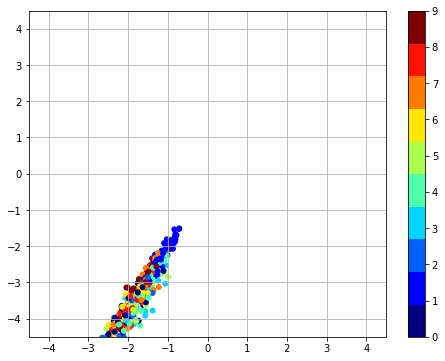

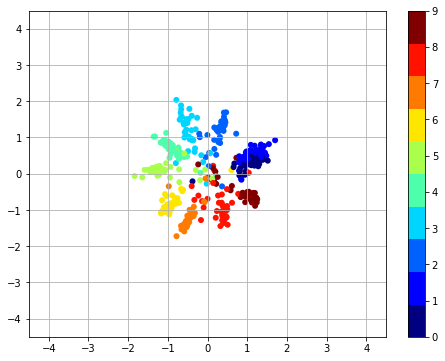

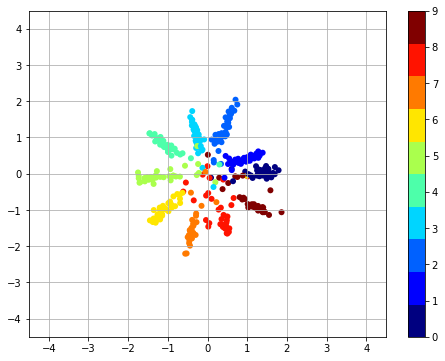

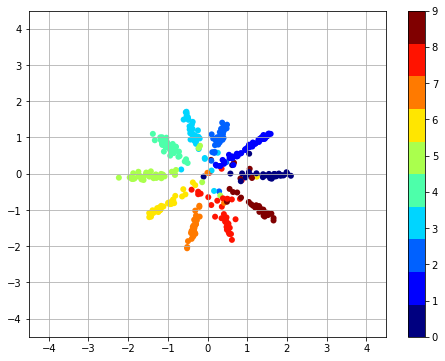

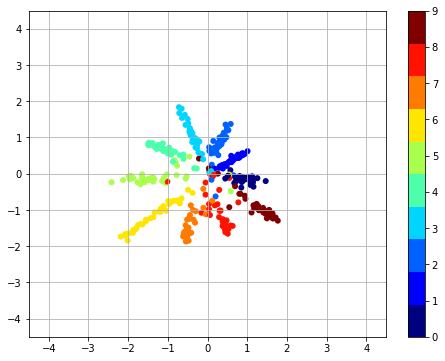

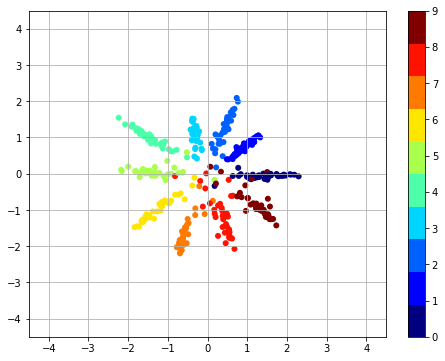

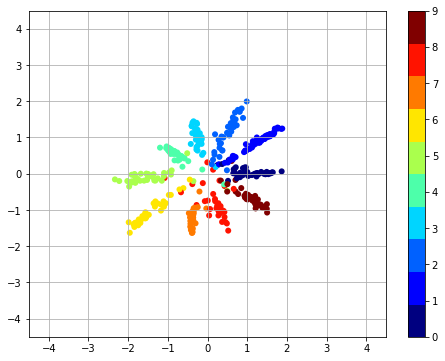

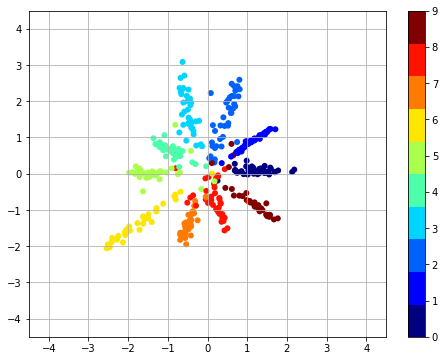

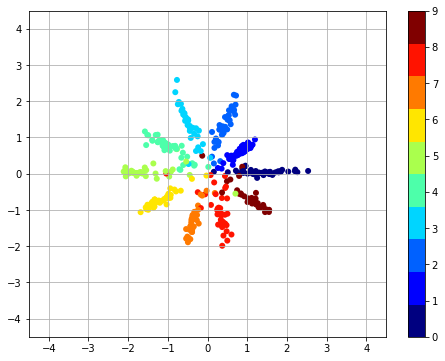

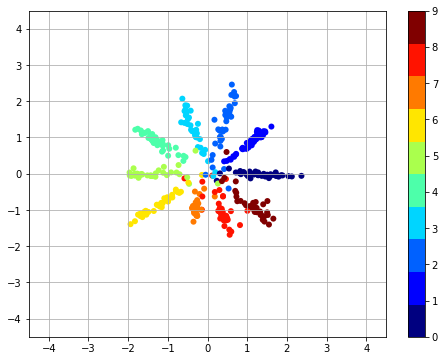

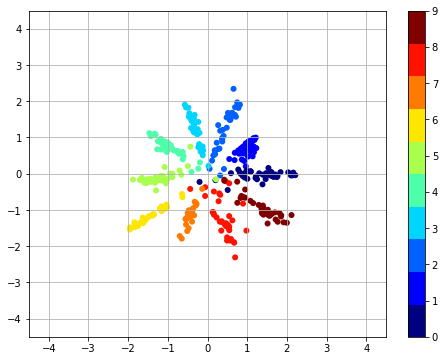

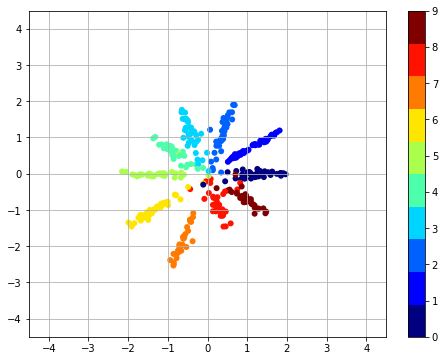

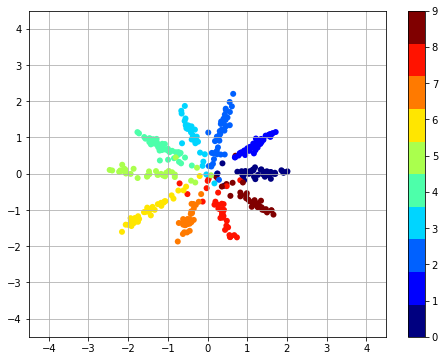

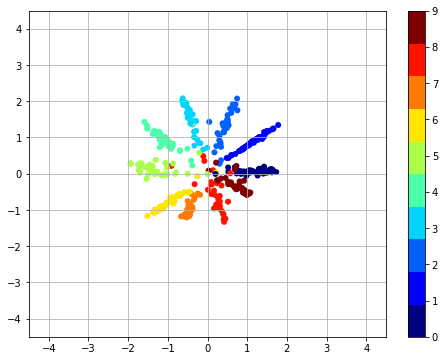

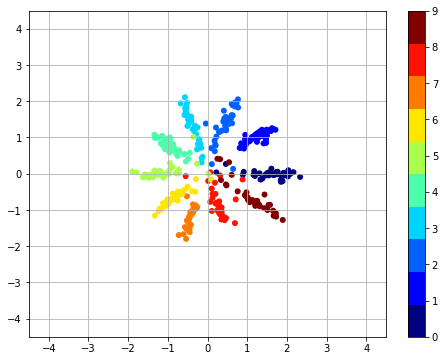

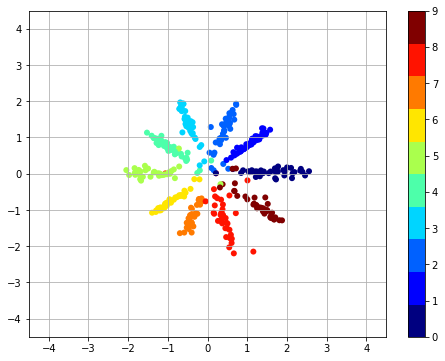

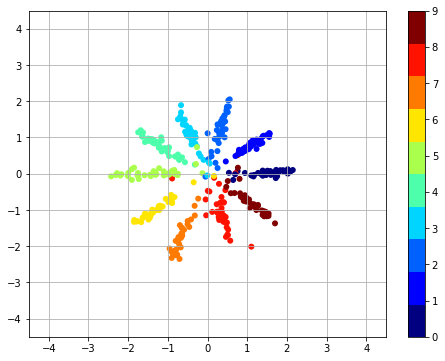

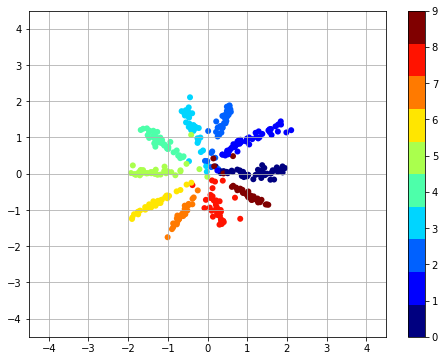

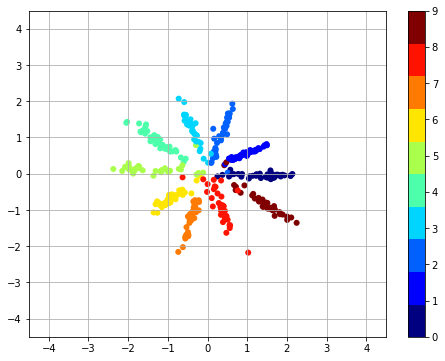

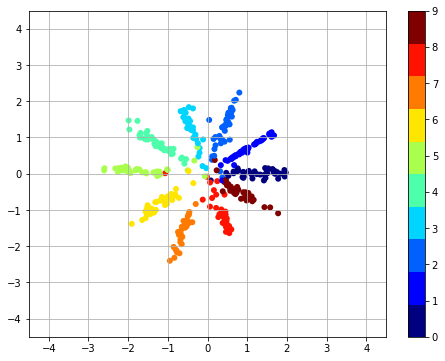

In [20]:
start_epoch = 0
start_batch_id = 0


num_steps = 6000
# loop for epoch
start_time = time.time()
sess = tf.Session()
sess.run(tf.global_variables_initializer(), feed_dict={keep_prob : 0.9})

for step_ind in range(num_steps):
    
    '''get the real data'''
    real_image_batch = mnist.train.next_batch(batch_size)
    batch_images,batch_labels = real_image_batch
    batch_images = batch_images.astype(np.float32)
    #batch_images = batch_images.reshape([batch_size,28,28,1]).astype(np.float32)
    batch_labels = real_image_batch[1].astype(np.float32)
    
    '''get the noise data'''
    if prior_type =='mixGaussian':
        z_label_rand = np.random.randint(0, 10, size=[batch_size])
        batch_z = gaussian_mixture(batch_size, z_dim, label_indices=z_label_rand)
    elif prior_type == 'swiss_roll':
        z_label_rand = np.random.randint(0, 10, size=[batch_size])
        batch_z = swiss_roll(batch_size, z_dim, label_indices=z_label_rand)
    elif prior_type == 'normal':
        batch_z, z_label_rand = gaussian(batch_size, z_dim, use_label_info=True)    
    else:
        raise Exception(f"[!] There is no option for {prior_type}" )

    z_id_one_hot_vector = np.zeros((batch_size, y_dim))
    z_id_one_hot_vector[np.arange(batch_size), z_label_rand] = 1
    
    feed_dict_input = {
        x_input:batch_images,
        x_target:batch_images,
        x_label:batch_labels,
        z_sample:batch_z,
        z_label:z_id_one_hot_vector,
        keep_prob: 0.9
    }
    '''update AE network''' 
    _, loss_likehood = sess.run([ae_optim, neg_marginal_likelihood], feed_dict=feed_dict_input)
    '''update discriminator network'''
    _, d_loss = sess.run([d_optim, D_loss], feed_dict=feed_dict_input)
    '''update generator network, run 2 times'''
    _, g_loss = sess.run([g_optim, G_loss], feed_dict=feed_dict_input)
    _, g_loss = sess.run([g_optim, G_loss], feed_dict=feed_dict_input)
     
    total_loss = loss_likehood + d_loss + g_loss
    # display training status
    print("Step: [%d] total_loss: %.8f d_loss: %.8f, g_loss: %.8f, ae_loss: %.8f" % (step_ind, total_loss, d_loss, g_loss, loss_likehood) )

    # save training results for every 300 steps
    if  np.mod(step_ind, 300) == 0:
        if plot == 'reproduce': #  Plot for reproduce performance
            img_samples = sess.run(images_reconstruction, feed_dict={x_input:test_batch_images, keep_prob:1})
            # put the "batch_size" images into one big canvas
            display(img_samples, None, None, batch_size, y_dim, img_w, img_h, image_dims, step_ind, plot='reproduce')
            
        elif plot == 'mainfold learning': # Plot for manifold learning result
            img_samples = sess.run(fake_images, feed_dict={z_hidden: z_pmlr, keep_prob:1})
            z_samples = sess.run(z_pred, feed_dict={x_input:x_input_pmlr, keep_prob: 1})
            display(img_samples, z_samples, x_label_prml, batch_size, y_dim, img_w, img_h, image_dims, step_ind, plot='mainfold learning')


In [14]:
x_label_prml.shape

(400, 10)

In [17]:
samples.shape

(400, 784)